# Titanic Dataset Onboarding
This notebook provides an introduction to the Titanic dataset. The dataset contains information about passengers aboard the Titanic, including their survival status, age, class, and other attributes. We will explore and analyze this dataset.

In [93]:
# Load Required Libraries
import pandas as pd             # basic data manipulation built on NumPy
import numpy as np              # numerical operations 
import seaborn as sns           # statistical data visualization built on Matplotlib
import matplotlib.pyplot as plt # plotting library for Python
import sklearn as sk            # machine learning library for Python

In [94]:
dataset = sns.load_dataset("titanic") # Load the Titanic Dataset 
dataset.head() # Preview the Dataset


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


c:\Users\Mehdi\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\Mehdi\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


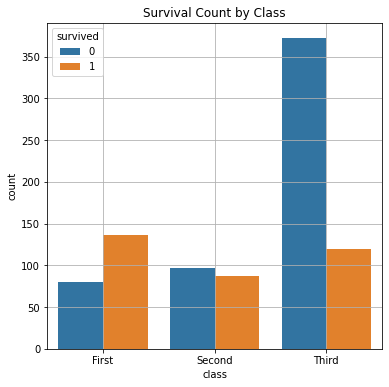

In [95]:
fig, ax = plt.subplots(figsize=(6, 6))                         # Create a figure and axis for plotting
sns.countplot(data=dataset, x='class', hue='survived', ax=ax)   # Create a count plot for 'class' vs 'survived'
ax.set_title('Survival Count by Class')                         # Set the title of the plot
ax.grid(True)                                                   # Add grid lines to the plot

Total Passengers: 891
Total Survivors: 342
Overall Probability of Survival: 0.38


Text(0.5, 1.0, 'Probability of Survival by Class')

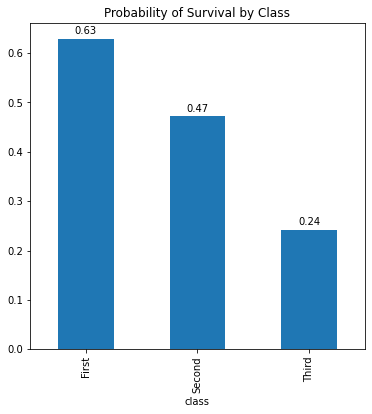

In [96]:
# Calculate Total Passengers and Survivors
total_ppl = dataset.shape[0]  # Total number of passengers
total_survived = dataset['survived'].sum()  # Total number of survivors

# Calculate Survivors by Class
total_survived_by_class = dataset.groupby('class', observed=False)['survived'].sum()  # Total survivors by class

# Calculate Probability of Survival
probability_of_survival = total_survived / total_ppl  # Overall probability of survival
probability_of_survival_by_class = total_survived_by_class / dataset.groupby('class', observed=False).size()  # Probability of survival by class

# Display Results
print(f"Total Passengers: {total_ppl}")
print(f"Total Survivors: {total_survived}")
print(f"Overall Probability of Survival: {probability_of_survival:.2f}")
fig, ax = plt.subplots(figsize=(6, 6))  # Create a new figure and axis for the probability plot
probability_of_survival_by_class.plot(kind='bar', ax=ax)  # Plot the probability of survival by class
for i, v in enumerate(probability_of_survival_by_class):
    ax.text(i, v + 0.005, f"{v:.2f}", ha='center', va='bottom')  # Add text on top of each bar
ax.set_title('Probability of Survival by Class')  # Set the title of the probability plot

The 1st naive model can be used to predict the chance of survival based only on class
We can now calculate the performance of this 1st naive model by comparing the predicted survival probabilities with the actual survival outcomes in the dataset. 
The idea is to calculate randomly if a passenger survived based on the class they were in, using the probabilities we derived earlier.

In [97]:
def monte_carlo_survival_predict(pclass, survival_probs = {'First': 0.63, 'Second': 0.47, 'Third': 0.24}):
    """
    For a given passenger class, draw 1 (survive) with the empirical survival probability.
    """
    prob = survival_probs[pclass]
    return int(np.random.rand() < prob)


In [111]:
#make an iteration to predict survival for each passenger
for index, row in dataset.iterrows():
    dataset.at[index, 'Monte_Carlo_Prediction'] = monte_carlo_survival_predict(row['class'])
#display the first few rows of the dataset to see the predictions
dataset['Monte_Carlo_Prediction'] = dataset['Monte_Carlo_Prediction'].astype(int)  # Ensure predictions are integers
dataset[['class', 'survived', 'Monte_Carlo_Prediction']].head()

,class,survived,Monte_Carlo_Prediction
0,Third,0,0
1,First,1,1
2,Third,1,0
3,First,1,1
4,Third,0,1


Classical way to score the model is to used a confusion matrix, correctly predicted vs incorrectly predicted for each class.

In [112]:
for name, subdf in dataset.groupby('class', observed=False):
    n_passagers = len(subdf)
    n_errors = (subdf["survived"] != subdf["Monte_Carlo_Prediction"]).sum()
    error_rate = n_errors / n_passagers
    print(f"Class {name}: {n_errors} errors out of {n_passagers} ({error_rate:.2%})")


Class First: 103 errors out of 216 (47.69%)
Class Second: 85 errors out of 184 (46.20%)
Class Third: 176 errors out of 491 (35.85%)


So this is the very first naive model we can build with this dataset, which is based on the class of the passengers.
This model serves as a baseline for further improvements and more complex models that can be developed later.